# More and More Types of Pooling...

Here I used "sum units", which are basically units that sum the total value along one dimension of their input. In this case it sums the values of each of the filterrs. Ideally this should perform at least as well as HAL, since it's essentially doing a similar thing but it has more information on relationships between different filters so it should capture some more information.

In [4]:
%matplotlib inline
from keras.models import Sequential, model_from_json
from keras.layers import Convolution1D, LSTM, GRU, Dense, Activation, Dropout, MaxPooling1D, Flatten, BatchNormalization
from keras.objectives import binary_crossentropy, categorical_crossentropy
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence

import sys
import os
sys.path.append(os.path.abspath('../src/'))
import nn_utils
import keras_pooling
reload(nn_utils)
reload(keras_pooling)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.cross_validation import train_test_split

import tqdm
import cPickle

In [5]:
num_filters = [100,64,32]
filter_length = [10,4,6]

model1 = Sequential()
model1.add(Convolution1D(num_filters[0], filter_length[0], activation='relu', input_dim=4))
model1.add(Dropout(0.25))
model1.add(Convolution1D(num_filters[1], filter_length[1], activation='relu', input_dim=4))
model1.add(keras_pooling.SumLayer())
model1.add(Flatten())
model1.add(Dense(output_dim=1, activation='linear'))
model1.add(Activation('sigmoid'))

In [6]:
model1.compile(loss='binary_crossentropy',
              optimizer='adam')

In [7]:
X_train, X_test, Y_train, Y_test = nn_utils.load_a5_data()
Y2_test = Y_test[:,44]
Y2_train = Y_train[:,44]
X1_train = X_train.map(lambda x: x[0:25])
X1_test = X_test.map(lambda x: x[0:25])
#X1_train = X1_train.map(lambda x: np.rollaxis(x, 1))
#X1_test = X1_test.map(lambda x: np.rollaxis(x, 1))
X1_train = np.dstack(X1_train)
X1_train = np.rollaxis(X1_train, 2)
X1_test = np.dstack(X1_test)
X1_test = np.rollaxis(X1_test, 2)

Y2_train = Y2_train.reshape((len(Y2_train), 1))
Y2_test = Y2_test.reshape((len(Y2_test), 1))

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

model1.fit(X1_train, Y2_train,
          nb_epoch=50,
          batch_size=500,
          show_accuracy=True,
          validation_data=(X1_test, Y2_test),
          callbacks=[early_stopping])

Train on 212035 samples, validate on 53009 samples
Epoch 1/50
212035/212035 [==============================] - 1257s - loss: 0.5994 - acc: 1.0000 - val_loss: 0.5724 - val_acc: 1.0000
Epoch 2/50
212035/212035 [==============================] - 1254s - loss: 0.5618 - acc: 1.0000 - val_loss: 0.5555 - val_acc: 1.0000
Epoch 3/50
212035/212035 [==============================] - 1259s - loss: 0.5541 - acc: 1.0000 - val_loss: 0.5500 - val_acc: 1.0000
Epoch 4/50
212035/212035 [==============================] - 5640s - loss: 0.5500 - acc: 1.0000 - val_loss: 0.5423 - val_acc: 1.0000
Epoch 5/50
212035/212035 [==============================] - 1278s - loss: 0.5478 - acc: 1.0000 - val_loss: 0.5440 - val_acc: 1.0000
Epoch 6/50
212035/212035 [==============================] - 1410s - loss: 0.5473 - acc: 1.0000 - val_loss: 0.5395 - val_acc: 1.0000
Epoch 7/50
212035/212035 [==============================] - 1273s - loss: 0.5458 - acc: 1.0000 - val_loss: 0.5395 - val_acc: 1.0000
Epoch 8/50
212035/212035 

In [9]:
table1 = pd.read_table('../data/mmc2.tsv')
wt_seqs = table1.WT_SEQ
mut_seqs = table1.MUT_SEQ
wt_seqs_encoded = [nn_utils.seq_to_array(x) for x in wt_seqs]
mut_seqs_encoded = [nn_utils.seq_to_array(x) for x in mut_seqs]
wt_seqs_encoded = map(lambda x: x.reshape((1, x.shape[0], x.shape[1])), wt_seqs_encoded)
mut_seqs_encoded = map(lambda x: x.reshape((1, x.shape[0], x.shape[1])), mut_seqs_encoded)

In [10]:
from keras import backend as K

expit = lambda x: 1./(1.+np.exp(-x))
logit = lambda x: np.log(x)-np.log(1-x)

get_3rd_layer_output_1 = K.function([model1.layers[0].input],
                                  [model1.layers[-2].get_output(train=False)])
def get_score(input_data):
    return get_3rd_layer_output_1([input_data])[0]
    #return (get_3rd_layer_output_2([input_data])[0] + get_3rd_layer_output_1([input_data])[0])/2

def get_delta_psi(wt_seq, mut_seq, wt_psi):
    score_wt = get_score(wt_seq)
    score_mut = get_score(mut_seq)
    mut_psi = expit(score_mut - score_wt + logit(wt_psi))
    return mut_psi - wt_psi

In [11]:
nn_delta_psi = [get_delta_psi(w, m, p) for w, m, p in tqdm.tqdm(zip(wt_seqs_encoded, mut_seqs_encoded, table1.WT_PSI))]

In [12]:
model_dpsi_pred = [x[0][0] for x in nn_delta_psi]

In [13]:
hal_pred = []
model_pred = []
for h, m in zip(table1.HOMO_DPSI_PRED, model_dpsi_pred):
    if h!=None and h>=-1 and h<=1:
        hal_pred.append(h)
        model_pred.append(m)

In [14]:
r2_score(hal_pred, model_pred)

-0.04879806390171626

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


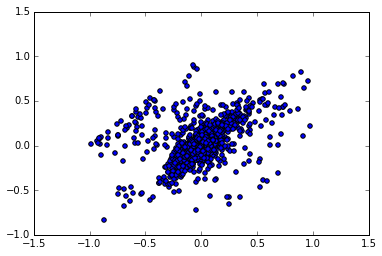

In [15]:
plt.scatter(hal_pred, model_pred)

In [16]:
score_mut = hal_pred_2 = []
model_pred_2 = []
actual = []
pos_or_neg = []
for h, m, a in zip(table1.HOMO_DPSI_PRED, model_dpsi_pred, table1.HOMO_DPSI):
    if h!=None and h>=-1 and h<=1 and a>=-1 and a<=1:
        hal_pred_2.append(h)
        model_pred_2.append(m)
        actual.append(a)
        if h>=0 and m>=0:
            pos_or_neg.append(1)
        elif h<=0 and m<=0:
            pos_or_neg.append(0)

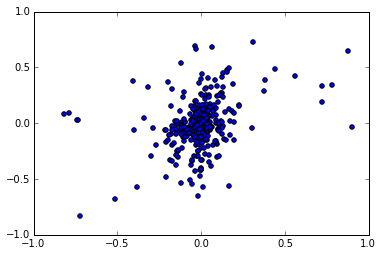

In [17]:
plt.scatter(actual, model_pred_2)

In [19]:
r2_score(model_pred_2, actual)

-0.108336125060007

In [20]:
float(sum(pos_or_neg))/float(len(pos_or_neg))

0.47096774193548385

In [21]:
# woah this actually is better than before!!!!!
model1.save_weights('../data/convolutional-sum.h5')
model_json = model1.to_json()
with open('../data/convolutional-sum-model.json', 'w') as f:
    f.write(model_json)

Okay so this was the first neural network model that performed even a little acceptably on the mutation dataset. What can we do to make it better, maybe even better than HAL? We can make deeper and bigger layers, for one. Also we could have a model for the actual splice site like HAL does.